In [66]:
# import lovelyplots
import lovelyplots
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import scienceplots
from matplotlib import tri
from matplotlib.colors import TwoSlopeNorm
from qutip import (
    average_gate_fidelity,
    destroy,
    qeye,
    tensor,
)
from qutip_qip.operations import ISWAP, SQRTISWAP
from tqdm.notebook import tqdm

In [67]:
# params
N = 50
g3 = 60e6  # (g3 = 60 Mhz / 2pi)
lambdaq = 0.08
n_s_list = np.linspace(2, 5, N)  # sqrt of pump photon number in SNAIL mode
delta_list = 1e6 * np.linspace(150, 400, 8)  # MHz

# full_pulse = geff * t_f => geff = full_pulse / t_f
# pi/2 pulse for iSWAP, pi/4 for sqrtiSWAP
if True:
    full_pulse = np.pi / 2
    intended_gate = ISWAP([0, 1]).get_compact_qobj()
else:
    full_pulse = np.pi / 4
    intended_gate = SQRTISWAP([0, 1]).get_compact_qobj()

# define qutip ladder operators
q = destroy(2)
q1 = tensor(q, qeye(2), qeye(2), qeye(2))
q2 = tensor(qeye(2), q, qeye(2), qeye(2))
q3 = tensor(qeye(2), qeye(2), q, qeye(2))
q4 = tensor(qeye(2), qeye(2), qeye(2), q)
q1dag = q1.dag()
q2dag = q2.dag()
q3dag = q3.dag()
q4dag = q4.dag()

In [68]:
fidelity_dict = {}  # to store fidelity values for each delta
tf_dict = {}  # to store g_eff values for each delta

for delta in tqdm(delta_list):
    fidelity_list = []
    tf_list = []  # store g_eff for this delta
    for n_s in n_s_list:
        eta = np.sqrt(n_s)
        g_eff = 6 * eta * g3 * (lambdaq**2)
        t_f = full_pulse / g_eff

        # H(t) = g_eff * exp(-i * delta * t) * interaction_term
        interaction_term = q1dag * q2 + q1 * q2dag
        spectator_term = q3dag * q4 + q3 * q4dag
        # spectator_term = q2dag + q2

        # Integral of the exponential factor
        # integral_term = (1j *(-1 + np.cos(t_f * delta)))/delta + np.sin(t_f * delta)/delta
        integral_term = 2 * np.sin(t_f * delta / 2) / delta

        # Time evolution operator U(t_f)
        # NOTE sqrt(2) to scale to scale spectator to be on both left and right of intended
        multiple_scale_factor = 1 / np.log(2)
        U_t_f = (
            1j
            * g_eff
            * (
                t_f * interaction_term
                + multiple_scale_factor * integral_term * (spectator_term)
            )
        ).expm()

        # Fidelity calculation
        # Define the target iSWAP gate
        # target_iswap = tensor(ISWAP([0, 1]).get_compact_qobj(), qeye([2, 2]))
        target_iswap = tensor(intended_gate, qeye([2, 2]))
        fidelity = 1 - average_gate_fidelity(U_t_f, target_iswap)
        fidelity_list.append(fidelity)
        tf_list.append(t_f)

    # Store fidelity list and g_eff list for current delta
    fidelity_dict[delta] = fidelity_list
    tf_dict[delta] = tf_list

  0%|          | 0/8 [00:00<?, ?it/s]

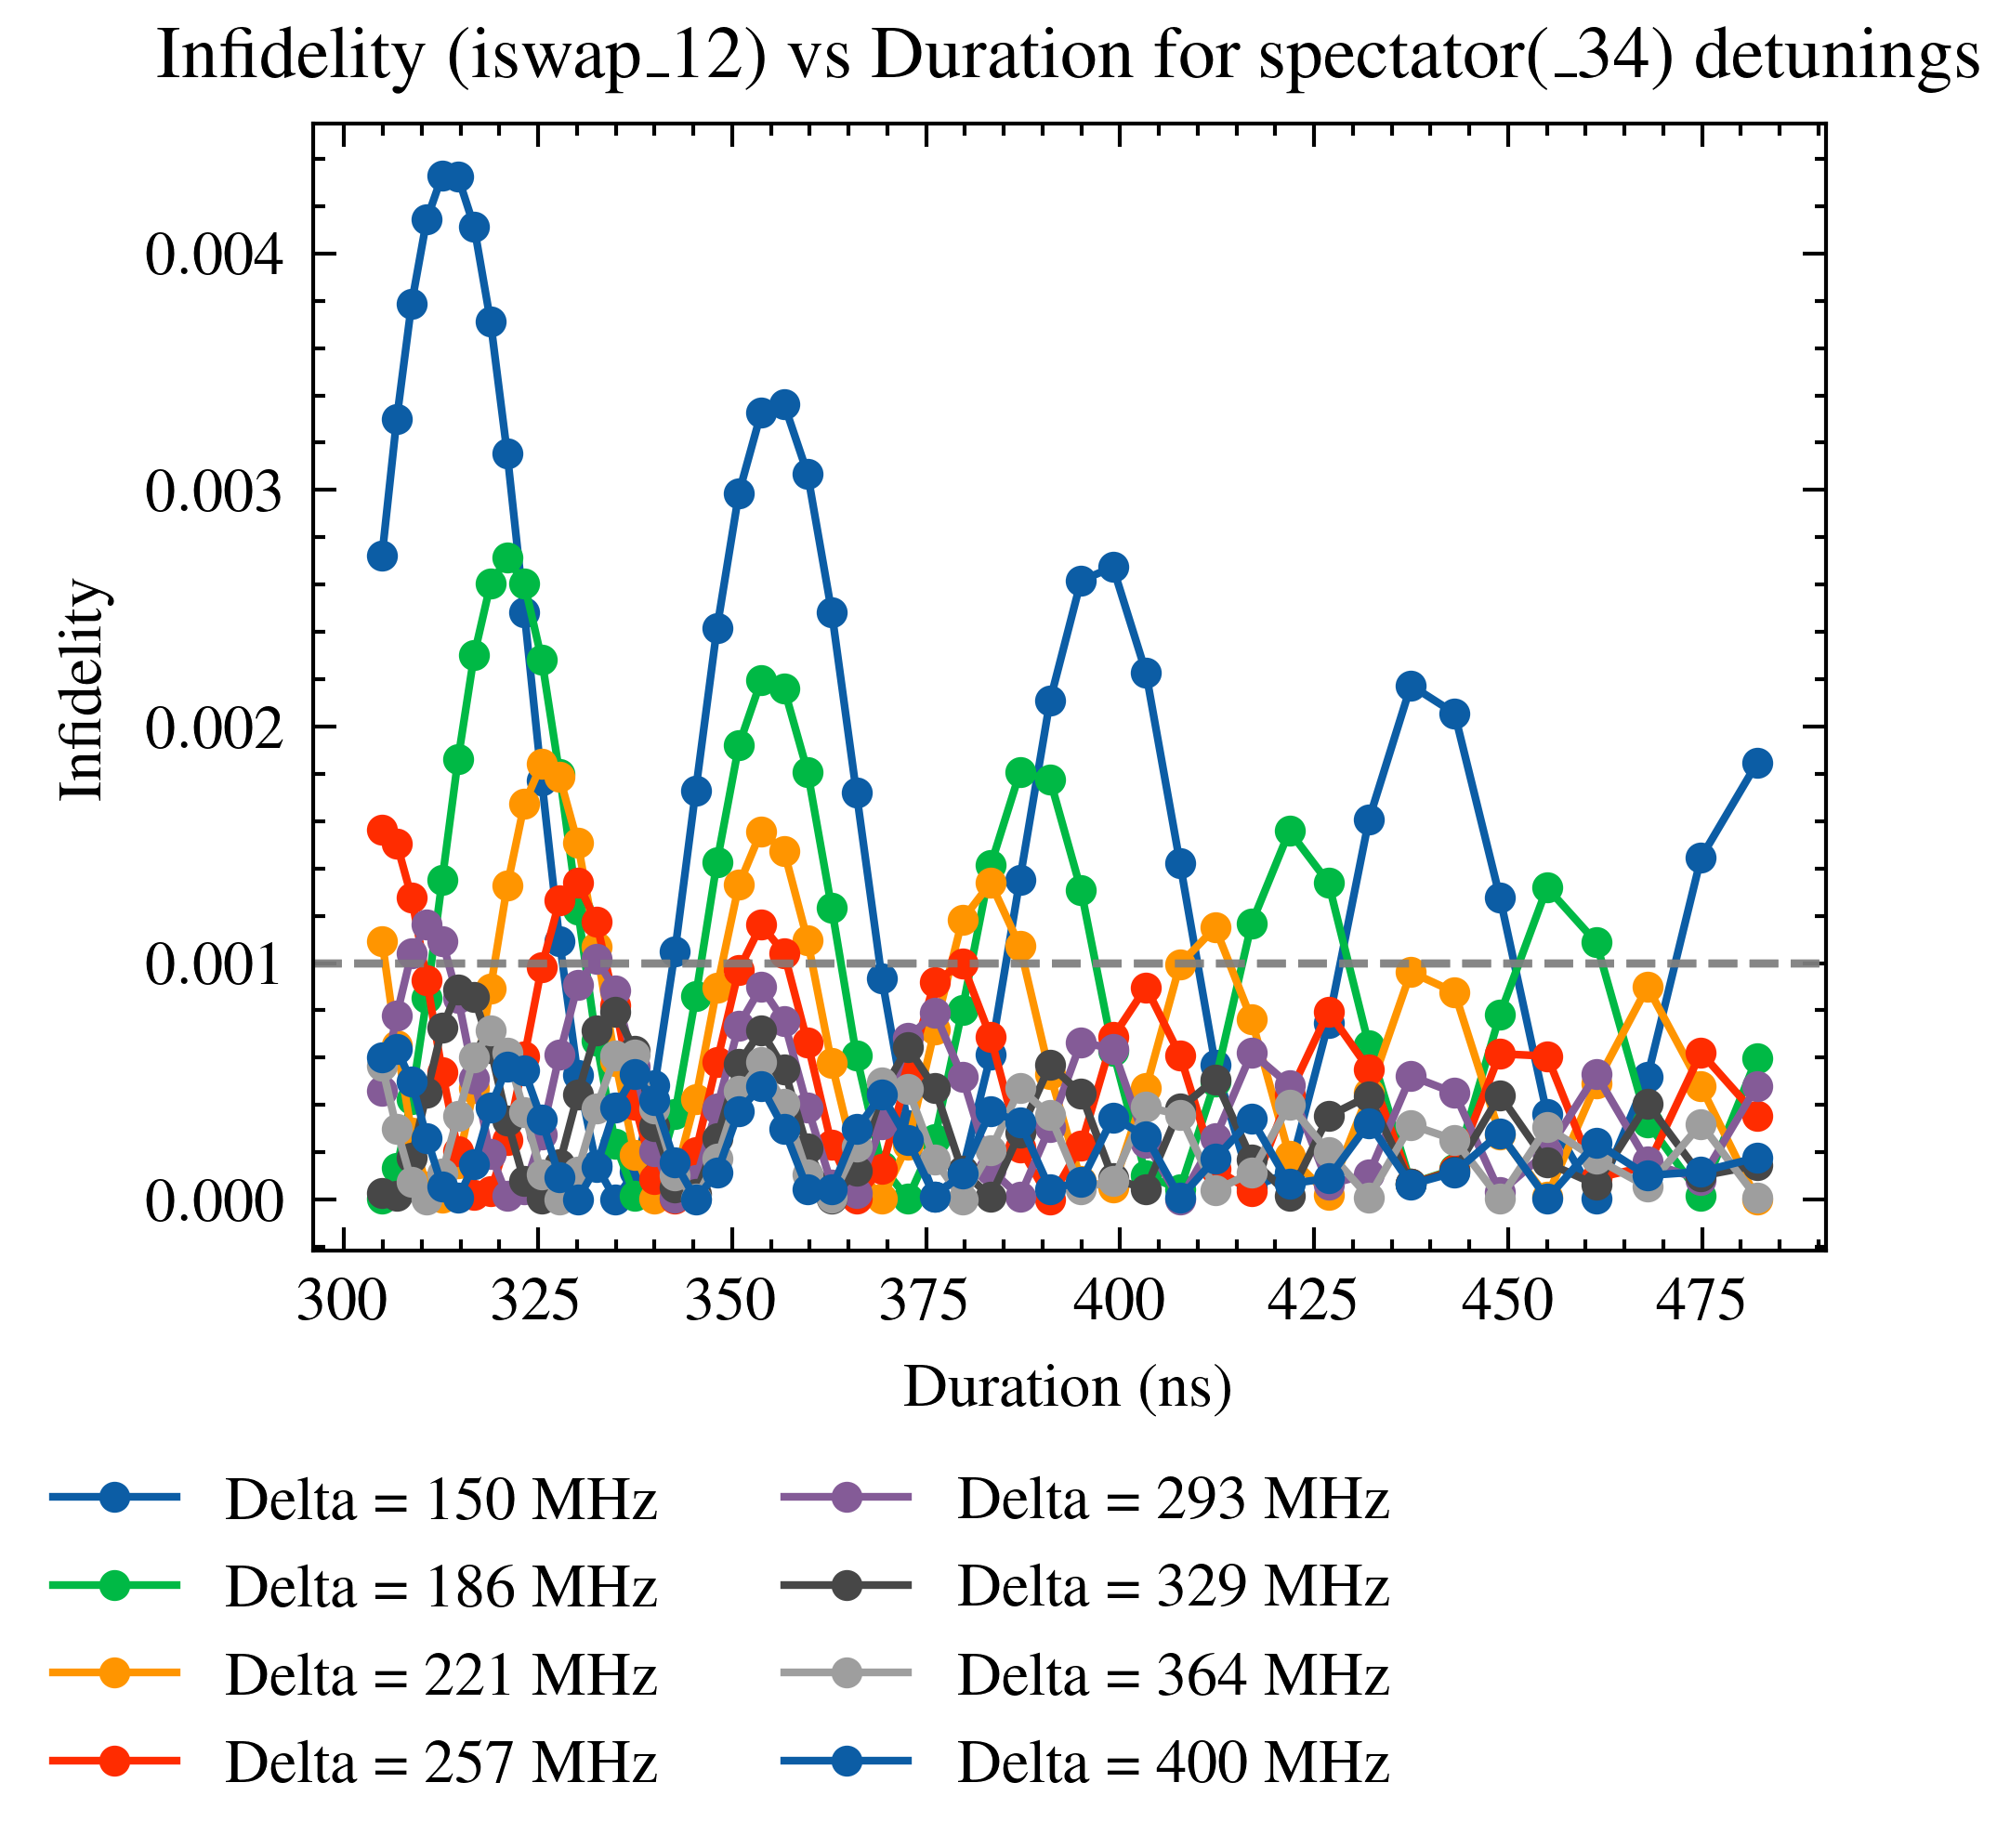

In [69]:
with plt.style.context(["ieee", "use_mathtext", "science"]):
    # rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

    # Plotting fidelity as a function of g_eff for each delta
    for delta, fidelity_list in fidelity_dict.items():
        tf_list = np.array(tf_dict[delta]) * 1e9  # convert to ns
        plt.plot(
            tf_list, fidelity_list, label=f"Delta = {delta/1e6:.0f} MHz", marker="."
        )
        # plt.plot(
        #     tf_list,
        #     len(fidelity_list) * [np.max(fidelity_list)],
        #     color="gray",
        #     alpha=0.3,
        # )
        # plot hline at 1-.999
        plt.axhline(1 - 0.999, color="gray", linestyle="--", alpha=0.3)

    # set xaxis to use ns instead of scientific notation
    plt.ticklabel_format(style="plain", axis="x")
    plt.xlabel("Duration (ns)")
    plt.ylabel("Infidelity")
    plt.title("Infidelity (iswap_12) vs Duration for spectator(_34) detunings")
    plt.legend(ncols=len(fidelity_dict) // 4, bbox_to_anchor=(0.75, -0.15))
    plt.show()

In [70]:
# update parameter sweep lists such that have fine-grain over delta and coarse n_s
n_s_list = np.linspace(2, 5, 3)  # sqrt of pump photon number in SNAIL mode
delta_list = 1e6 * np.linspace(1, 100, 256)  # MHz

fidelity_dict = {}  # to store fidelity values for each delta
tf_dict = {}  # to store g_eff values for each delta

for delta in tqdm(delta_list):
    fidelity_list = []
    tf_list = []  # store g_eff for this delta
    for n_s in n_s_list:
        eta = np.sqrt(n_s)
        g_eff = 6 * eta * g3 * (lambdaq**2)
        t_f = full_pulse / g_eff

        # H(t) = g_eff * exp(-i * delta * t) * interaction_term
        interaction_term = q1dag * q2 + q1 * q2dag
        spectator_term = q3dag * q4 + q3 * q4dag

        # Integral of the exponential factor
        # integral_term = (1j *(-1 + np.cos(t_f * delta)))/delta + np.sin(t_f * delta)/delta
        integral_term = 2 * np.sin(t_f * delta / 2) / delta

        # Time evolution operator U(t_f)
        # NOTE sqrt(2) to scale to scale spectator to be on both left and right of intended
        multiple_scale_factor = 1 / np.log(2)
        U_t_f = (
            1j
            * g_eff
            * (
                t_f * interaction_term
                + multiple_scale_factor * integral_term * (spectator_term)
            )
        ).expm()

        # Fidelity calculation
        # Define the target iSWAP gate
        # target_iswap = tensor(ISWAP([0, 1]).get_compact_qobj(), qeye([2, 2]))
        target_iswap = tensor(intended_gate, qeye([2, 2]))
        fidelity = 1 - average_gate_fidelity(U_t_f, target_iswap)
        fidelity_list.append(fidelity)
        tf_list.append(t_f)

    # Store fidelity list and g_eff list for current delta
    fidelity_dict[delta] = fidelity_list
    tf_dict[delta] = tf_list

  0%|          | 0/256 [00:00<?, ?it/s]

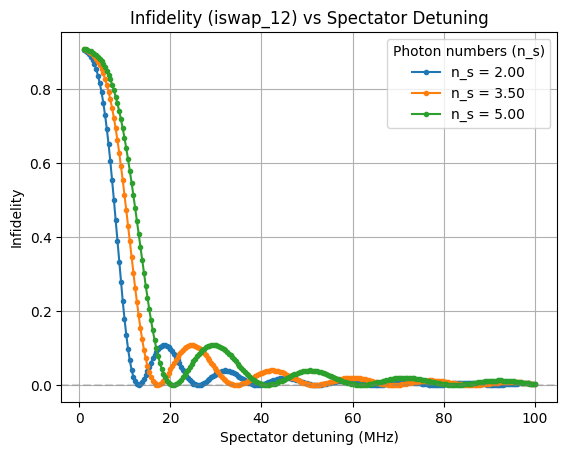

In [43]:
# Create a second version of the plot: fidelity vs. spectator detuning (delta)
plt.figure()

# Plot fidelity as a function of spectator detuning (delta)
for n_s_index, n_s in enumerate(n_s_list):
    fidelity_values = [fidelity_dict[delta][n_s_index] for delta in delta_list]
    deltas_mhz = np.array(delta_list) / 1e6  # Convert detuning to MHz
    plt.plot(deltas_mhz, fidelity_values, label=f"n_s = {n_s:.2f}", marker=".")

# Formatting the plot
plt.axhline(1 - 0.999, color="gray", linestyle="--", alpha=0.3)
plt.xlabel("Spectator detuning (MHz)")
plt.ylabel("Infidelity")
# plt.yscale("log")
plt.title("Infidelity (iswap_12) vs Spectator Detuning")
plt.legend(title="Photon numbers (n_s)", loc="upper right")
plt.grid(True)

# Display the plot
plt.show()

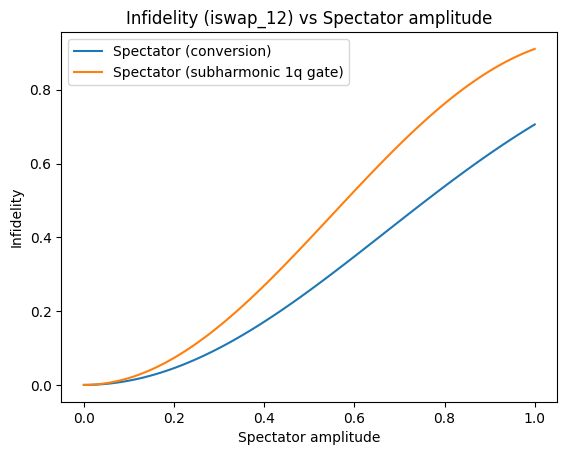

In [ ]:
intended_term = q1dag * q2 + q1 * q2dag

# Define two spectator terms for different types
spectator_term_conversion = q3dag * q4 + q3 * q4dag
spectator_term_subharmonic = q2dag + q2

# Create lists for fidelities and amplitudes
fidelity_list_conversion = []
fidelity_list_subharmonic = []
spectator_amplitude_list = np.linspace(0, 1.0, 100)
target_iswap = tensor(intended_gate, qeye([2, 2]))

# Calculate fidelity for conversion spectator term
for spectator_amplitude in spectator_amplitude_list:
    H_conversion = intended_term + spectator_amplitude * spectator_term_conversion
    U_t_f_conversion = (1.0j * (np.pi / 2) * H_conversion).expm()
    fidelity_conversion = 1 - average_gate_fidelity(U_t_f_conversion, target_iswap)
    fidelity_list_conversion.append(fidelity_conversion)

# Calculate fidelity for subharmonic spectator term
for spectator_amplitude in spectator_amplitude_list:
    H_subharmonic = intended_term + spectator_amplitude * spectator_term_subharmonic
    U_t_f_subharmonic = (1.0j * (np.pi / 2) * H_subharmonic).expm()
    fidelity_subharmonic = 1 - average_gate_fidelity(U_t_f_subharmonic, target_iswap)
    fidelity_list_subharmonic.append(fidelity_subharmonic)

# Plot results
plt.plot(
    spectator_amplitude_list, fidelity_list_conversion, label="Spectator (conversion)"
)
plt.plot(
    spectator_amplitude_list,
    fidelity_list_subharmonic,
    label="Spectator (subharmonic 1q gate)",
)
plt.xlabel("Spectator amplitude")
plt.ylabel("Infidelity")
plt.title("Infidelity (iswap_12) vs Spectator amplitude")
plt.legend()
plt.show()

Next, I need to justify the approximations used in the model:

that we can use only 4 qubits (1 spectator pair used twice) instead of 6 qubits (2 pairs of spectators) provided we have the right scaling factor $1/\log{2}$

  0%|          | 0/50 [00:00<?, ?it/s]

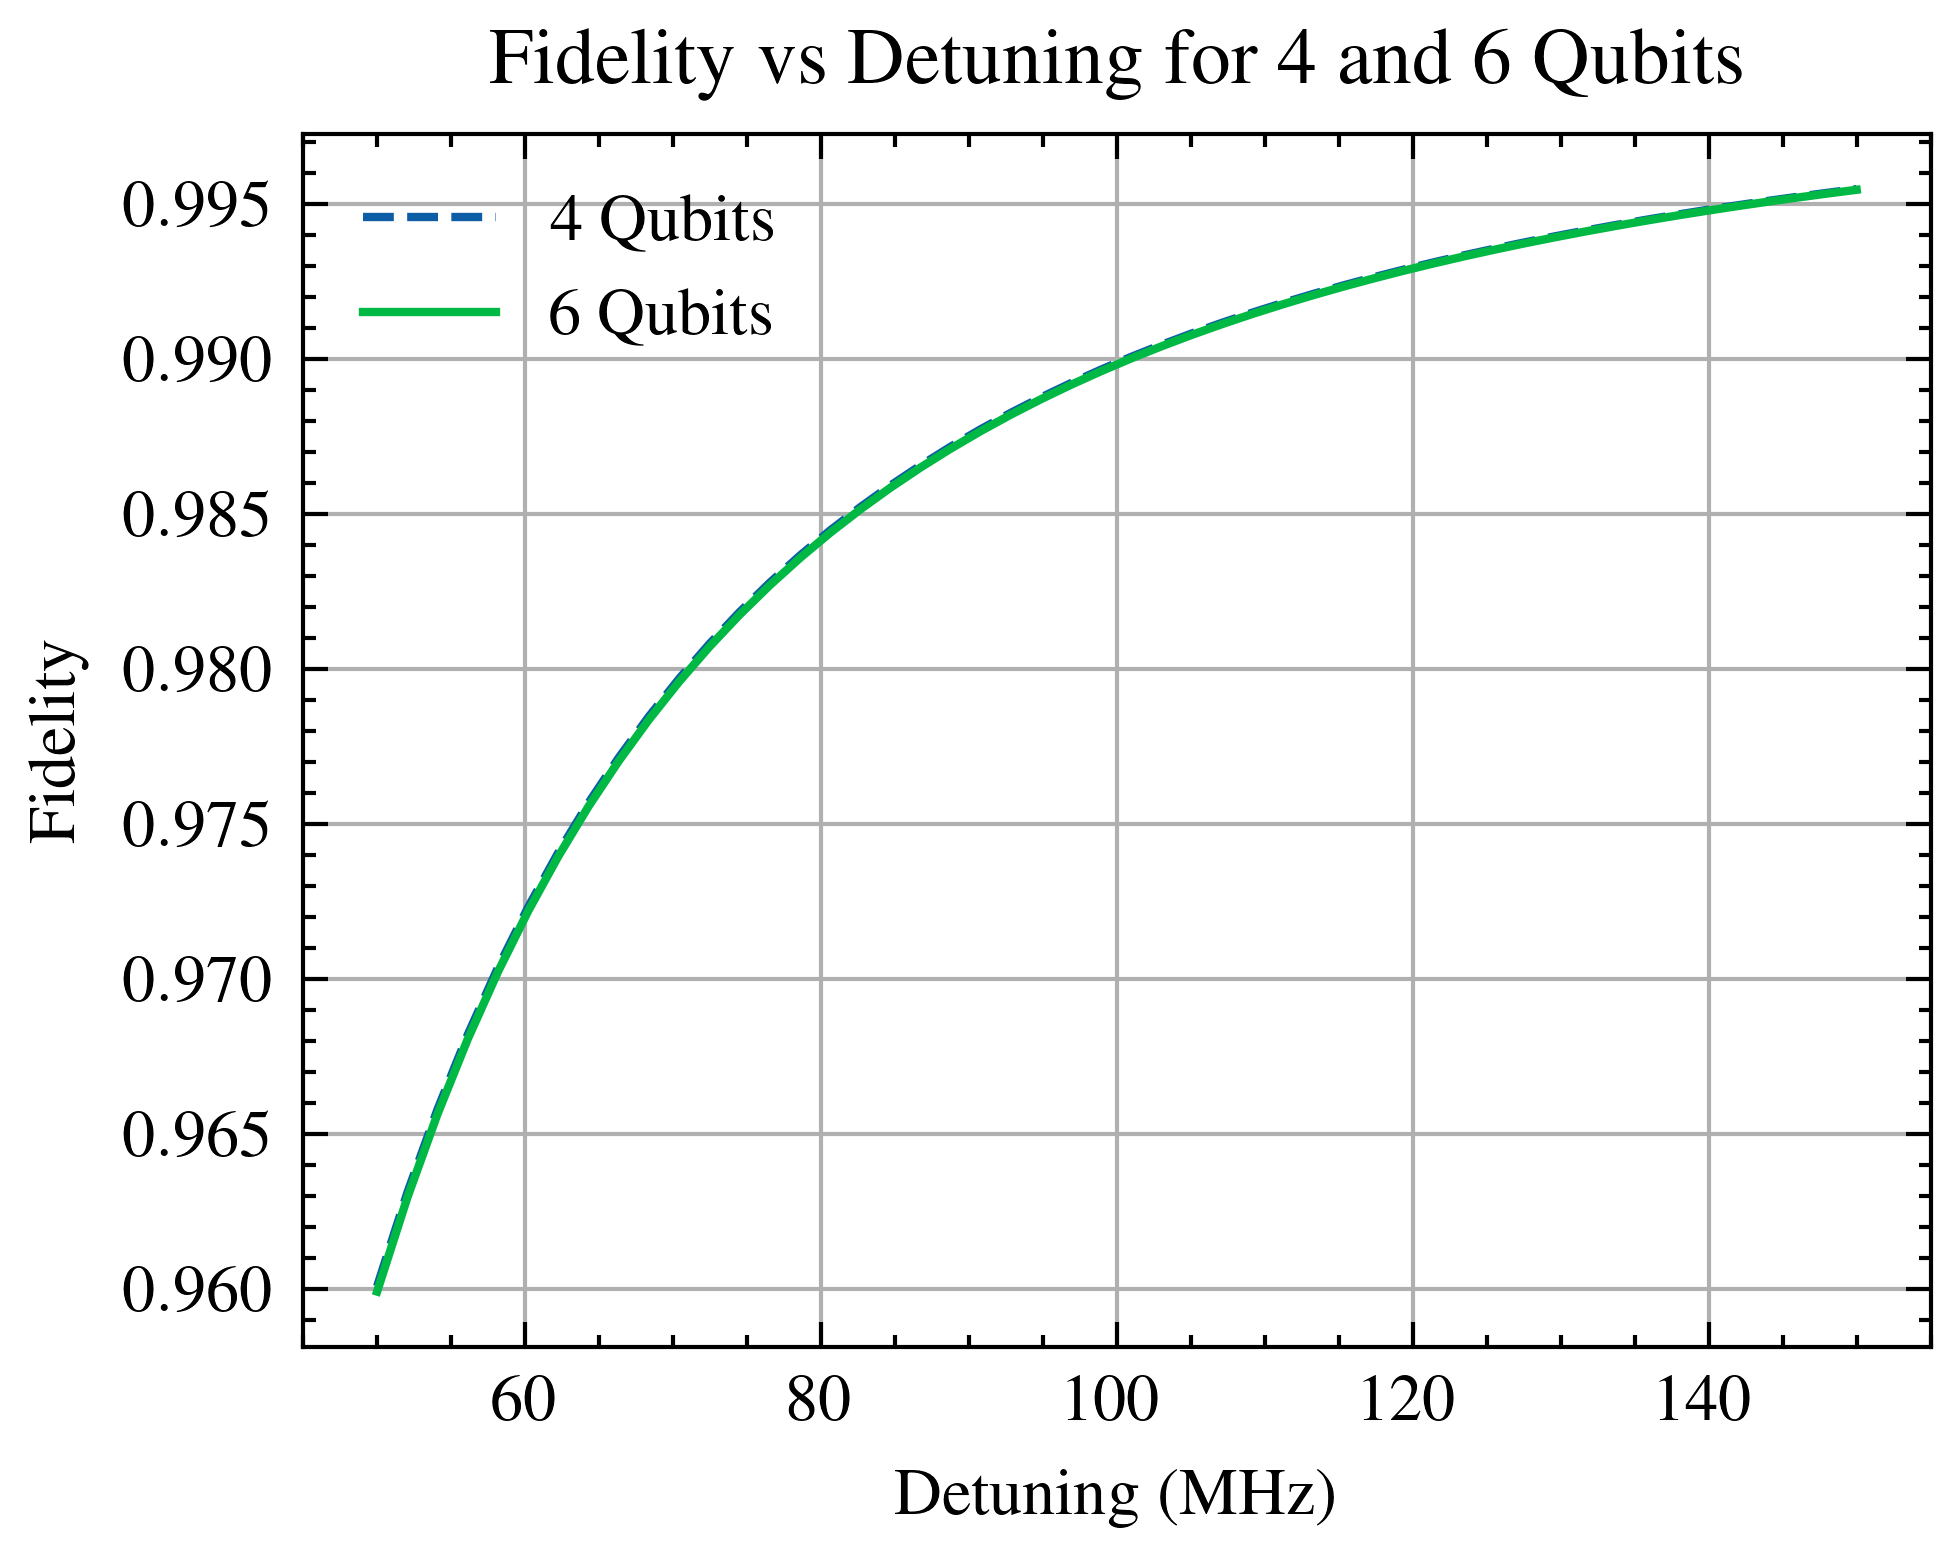

In [37]:
def build_propagator6(delta, lambdaq=0.1, g3=60e6, n_s=2, full_pulse=np.pi / 2):
    """Build propagator using 6 total qubits."""
    num_qubits = 6
    q1, q2, q3, q4, q5, q6 = [
        tensor(*[destroy(2) if i == j else qeye(2) for i in range(num_qubits)])
        for j in range(num_qubits)
    ]
    # Calculate effective coupling and gate duration t_f
    eta = np.sqrt(n_s)
    g_eff = 6 * g3 * (lambdaq**2) * eta
    t_f = full_pulse / g_eff  # Duration of the gate based on effective coupling

    # Define the target and spectator interactions
    target_interaction = q1.dag() * q2 + q1 * q2.dag()
    spectator_interaction1 = q3.dag() * q4 + q3 * q4.dag()
    spectator_interaction2 = q5.dag() * q6 + q5 * q6.dag()

    # Build the total Hamiltonian as a list of time-dependent components
    H_int = g_eff * target_interaction * t_f + g_eff * 2 / delta * (
        spectator_interaction1 + spectator_interaction2
    )
    U_spec = (1j * H_int).expm()

    return U_spec


def build_propagator4(delta, lambdaq=0.1, g3=60e6, n_s=2, full_pulse=np.pi / 2):
    """Build propagator using 4 total qubits, including a scaling prefactor."""
    num_qubits = 4
    q1, q2, q3, q4 = [
        tensor(*[destroy(2) if i == j else qeye(2) for i in range(num_qubits)])
        for j in range(num_qubits)
    ]

    # Calculate effective coupling and gate duration t_f
    eta = np.sqrt(n_s)
    g_eff = 6 * g3 * (lambdaq**2) * eta
    t_f = full_pulse / g_eff  # Duration of the gate based on effective coupling

    # Define the target and spectator interactions
    target_interaction = q1.dag() * q2 + q1 * q2.dag()
    spectator_interaction1 = q3.dag() * q4 + q3 * q4.dag()

    # Build the total Hamiltonian as a list of time-dependent components'
    constant = 1 / np.log(2)
    H_int = g_eff * target_interaction * t_f + constant * g_eff * 2 / delta * (
        spectator_interaction1
    )
    U_spec = (1j * H_int).expm()

    return U_spec


# Ueff = build_propagator6(100e6, lambdaq=0.1, g3=60e6, n_s=2, full_pulse=np.pi / 2)
# Udesired = tensor(ISWAP([0, 1]).get_compact_qobj(), qeye([2, 2, 2, 2]))
# average_gate_fidelity(Ueff, Udesired)

# Ueff = build_propagator4(100e6, lambdaq=0.1, g3=60e6, n_s=2, full_pulse=np.pi / 2)
# Udesired = tensor(ISWAP([0, 1]).get_compact_qobj(), qeye([2, 2]))
# average_gate_fidelity(Ueff, Udesired)


detunings = np.linspace(50e6, 150e6, N)  # Detuning range for plot
fid4 = []
fid6 = []

Udesired4 = tensor(ISWAP([0, 1]).get_compact_qobj(), qeye([2, 2]))
Udesired6 = tensor(ISWAP([0, 1]).get_compact_qobj(), qeye([2, 2, 2, 2]))

for delta in tqdm(detunings):

    # Calculate fidelities for 1 and 2 spectators
    Ueff = build_propagator4(delta, lambdaq=0.1, g3=60e6, n_s=2, full_pulse=np.pi / 2)
    fid4.append(average_gate_fidelity(Ueff, Udesired4))

    Ueff = build_propagator6(delta, lambdaq=0.1, g3=60e6, n_s=2, full_pulse=np.pi / 2)
    fid6.append(average_gate_fidelity(Ueff, Udesired6))

# Plot the results
with plt.style.context(["ieee", "use_mathtext", "science"]):
    plt.figure()
    plt.plot(detunings / 1e6, fid4, label="4 Qubits", linestyle="--")
    plt.plot(detunings / 1e6, fid6, label="6 Qubits", linestyle="-")
    plt.xlabel("Detuning (MHz)")
    plt.ylabel("Fidelity")
    plt.title("Fidelity vs Detuning for 4 and 6 Qubits")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def increment_unit(channel: int, last_value):
    """Increase voltage by single bit"""
    last_value = "000101010"
    register_contents = int(register_contents, 2) + 1
    register_contents = bin(register_contents)[2:].zfill(18)
    print(register_contents)


increment_unit()

TypeError: increment_unit() missing 2 required positional arguments: 'channel' and 'last_value'